In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from itertools import combinations


from darts import TimeSeries
from darts.models import ExponentialSmoothing, ARIMA, Prophet, RegressionEnsembleModel
from darts.metrics import mae
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

C:\Users\natha\AppData\Roaming\Python\Python38\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Load the uploaded dataset
path = 'C:/Users/natha/OneDrive/Bureau/Interview trainings/Coding/Aquatic/Weather_Forecast_Ideas/data/chicago_beach_weather.csv'
df = pd.read_csv(path)

# Convert 'Measurement Timestamp' column to datetime
df['Measurement Timestamp'] = pd.to_datetime(df['Measurement Timestamp'], format='%m/%d/%Y %I:%M:%S %p')

# Check for NaN or NULL directly
missing_summary = df.isnull().sum()

# Check for empty strings or common placeholders (e.g., 'NA', '-')
missing_summary['Station Name (Empty Strings)'] = (df['Station Name'] == '').sum()
missing_summary['Air Temperature (Empty Strings)'] = (df['Air Temperature'] == '').sum()

# Check for specific placeholders
placeholders = ['NA', '-', 'n/a', 'N/A', 'None', 'none', 'null', 'NULL', 'NaN', 'nan']
for placeholder in placeholders:
    missing_summary[f"Station Name ({placeholder})"] = (df['Station Name'] == placeholder).sum()
    missing_summary[f"Air Temperature ({placeholder})"] = (df['Air Temperature'].astype(str) == placeholder).sum()

print(missing_summary)

Station Name                       0
Measurement Timestamp              0
Air Temperature                    0
Station Name (Empty Strings)       0
Air Temperature (Empty Strings)    0
Station Name (NA)                  0
Air Temperature (NA)               0
Station Name (-)                   0
Air Temperature (-)                0
Station Name (n/a)                 0
Air Temperature (n/a)              0
Station Name (N/A)                 0
Air Temperature (N/A)              0
Station Name (None)                0
Air Temperature (None)             0
Station Name (none)                0
Air Temperature (none)             0
Station Name (null)                0
Air Temperature (null)             0
Station Name (NULL)                0
Air Temperature (NULL)             0
Station Name (NaN)                 0
Air Temperature (NaN)              0
Station Name (nan)                 0
Air Temperature (nan)              0
dtype: int64


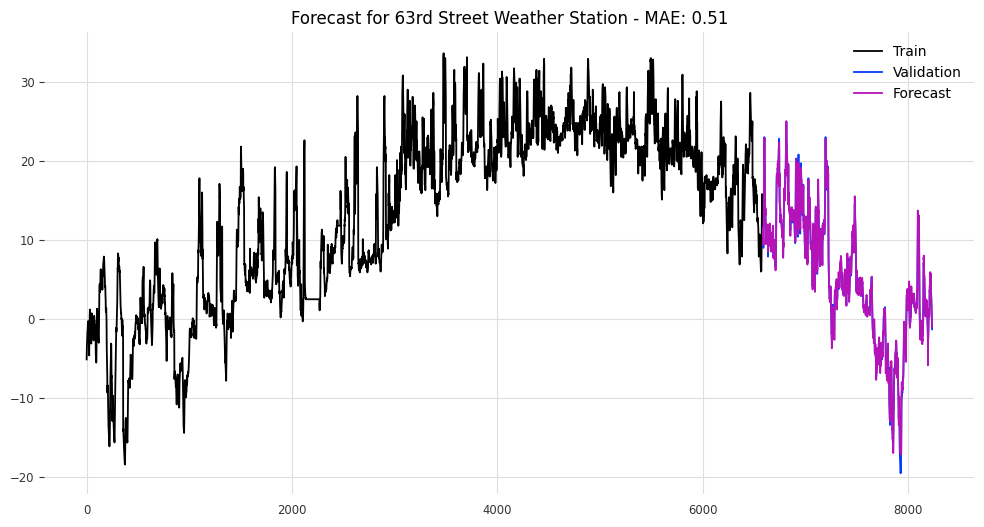

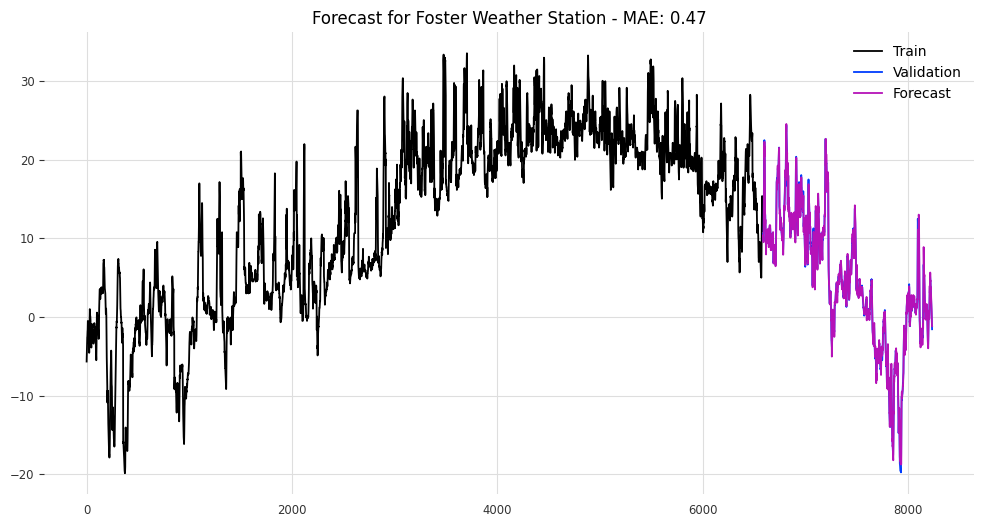

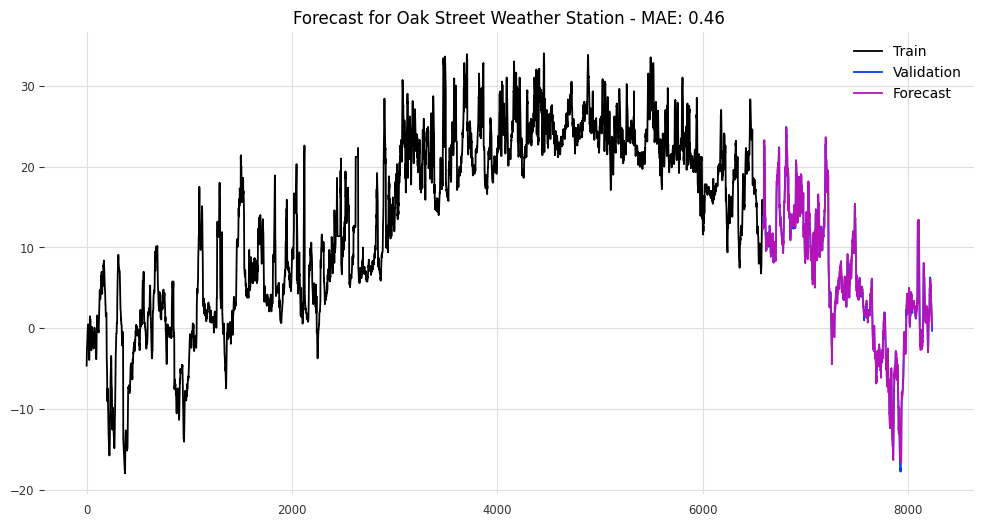

{'63rd Street Weather Station': 0.5144639858274829,
 'Foster Weather Station': 0.47328693964415125,
 'Oak Street Weather Station': 0.4618623214789101}

In [23]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Re-prepare df_pivot to ensure it exists
df_pivot = df.pivot(index='Measurement Timestamp', columns='Station Name', values='Air Temperature')
df_pivot = df_pivot.fillna(method='ffill').fillna(method='bfill')  # Fill missing values

# Prepare the data with lagged features for each station to predict all stations simultaneously
station_names = df_pivot.columns
lagged_data = pd.DataFrame()

# Create lagged features for each station
for station in station_names:
    for lag in range(1, 8):  # 7 lag days
        lagged_data[f'{station}_lag{lag}'] = df_pivot[station].shift(lag)

# Add each station's current value as a target
for station in station_names:
    lagged_data[f'target_{station}'] = df_pivot[station]

# Drop rows with NaN values after creating lags
lagged_data = lagged_data.dropna()

# Initialize a dictionary to store results for each station
mae_scores = {}
forecast_results = {}

# Train and predict for each station
for station in station_names:
    # Define X and y for the current station
    X = lagged_data.drop(columns=[f'target_{s}' for s in station_names])
    y = lagged_data[f'target_{station}']

    # Split into train and test sets, without shuffling to maintain time order
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Train the XGBoost model
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model.fit(X_train, y_train)

    # Predict and compute MAE
    y_pred = model.predict(X_test)
    mae_scores[station] = mean_absolute_error(y_test, y_pred)

    # Store the forecast, validation, and training sets for plotting
    forecast_results[station] = {
        'train': y_train,
        'validation': y_test,
        'forecast': y_pred
    }

# Plot the forecast, validation, and training sets for each station
for station in station_names:
    results = forecast_results[station]
    
    plt.figure(figsize=(12, 6))
    plt.plot(results['train'].values, label="Train")
    plt.plot(range(len(results['train']), len(results['train']) + len(results['validation'])), 
             results['validation'].values, label="Validation")
    plt.plot(range(len(results['train']), len(results['train']) + len(results['forecast'])), 
             results['forecast'], label="Forecast")
    plt.legend()
    plt.title(f"Forecast for {station} - MAE: {mae_scores[station]:.2f}")
    plt.show()

# Display MAE scores for each station
mae_scores


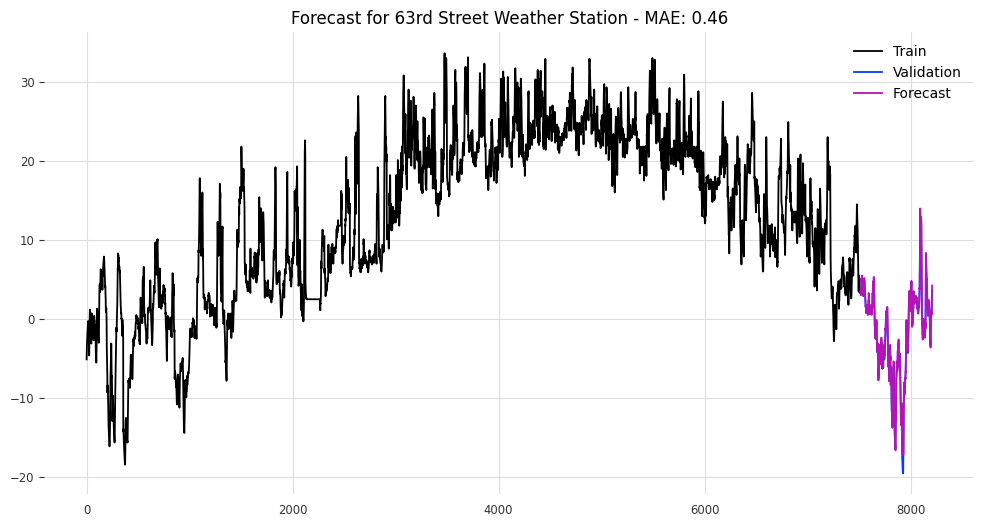

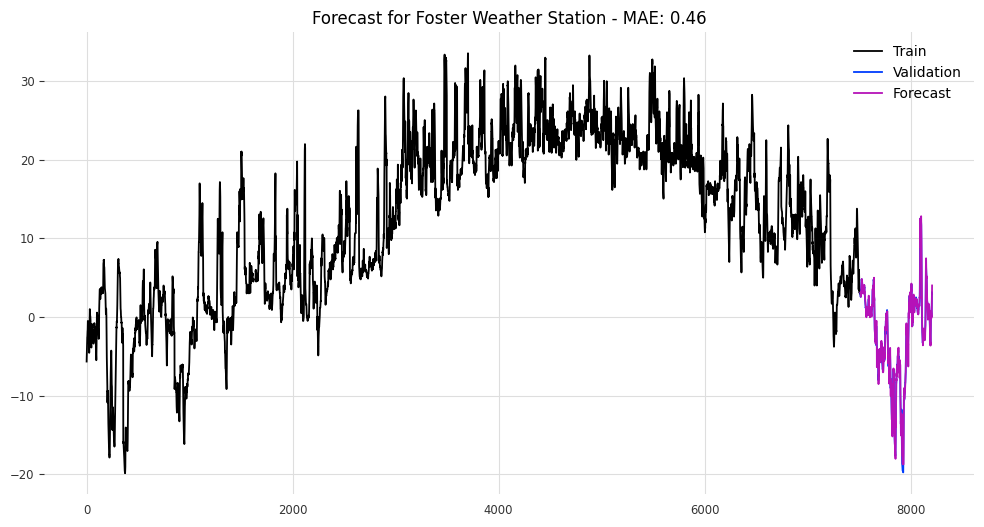

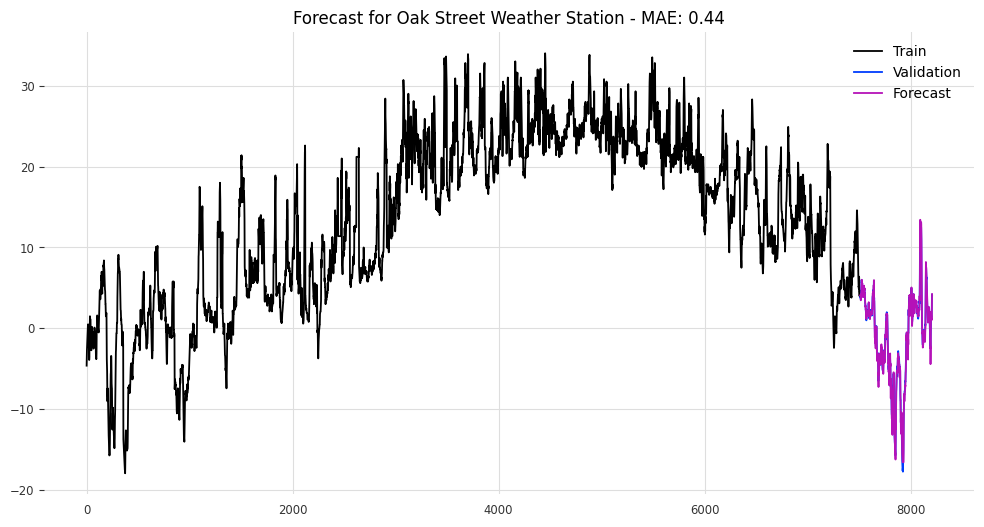

{'63rd Street Weather Station': 0.4636617418923756,
 'Foster Weather Station': 0.4607822521646084,
 'Oak Street Weather Station': 0.4443301489301442}

In [28]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd

# Load the CSV file to examine its contents
file_path = 'C:/Users/natha/OneDrive/Bureau/Interview trainings/Coding/Aquatic/Weather_Forecast_Ideas/data/chicago_beach_weather.csv'
weather_data = pd.read_csv(file_path)

# Display the first few rows of the data to understand its structure
weather_data.head()

# Preprocess the data as required
weather_data['Measurement Timestamp'] = pd.to_datetime(weather_data['Measurement Timestamp'])
weather_data.set_index('Measurement Timestamp', inplace=True)

# Pivot the data by station name and fill any missing values
df_pivot = weather_data.pivot(columns='Station Name', values='Air Temperature')
df_pivot = df_pivot.fillna(method='ffill').fillna(method='bfill')

# Generate lagged features
station_names = df_pivot.columns
lagged_data = pd.DataFrame()

# Create lagged features for each station
for station in station_names:
    for lag in range(1, 8):  # 7 lag days
        lagged_data[f'{station}_lag{lag}'] = df_pivot[station].shift(lag)

# Add each station's current value as a target
for station in station_names:
    lagged_data[f'target_{station}'] = df_pivot[station]

# Drop rows with NaN values after creating lags
lagged_data = lagged_data.dropna()

# Split data into training (before December) and validation (December only)
train_data = lagged_data[lagged_data.index < '2016-12-01']
val_data = lagged_data[(lagged_data.index >= '2016-12-01') & (lagged_data.index <= '2016-12-31')]

# Dictionary to store results for each station
mae_scores = {}
forecast_results = {}

# Train and predict for each station
for station in station_names:
    # Define X and y for the current station
    X_train = train_data.drop(columns=[f'target_{s}' for s in station_names])
    y_train = train_data[f'target_{station}']
    X_val = val_data.drop(columns=[f'target_{s}' for s in station_names])
    y_val = val_data[f'target_{station}']

    # Train the XGBoost model
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model.fit(X_train, y_train)

    # Predict and compute MAE for validation set
    y_pred = model.predict(X_val)
    mae_scores[station] = mean_absolute_error(y_val, y_pred)

    # Store the forecast, validation, and training sets for plotting
    forecast_results[station] = {
        'train': y_train,
        'validation': y_val,
        'forecast': y_pred
    }

# Plot the forecast, validation, and training sets for each station
for station in station_names:
    results = forecast_results[station]
    
    plt.figure(figsize=(12, 6))
    plt.plot(results['train'].values, label="Train")
    plt.plot(range(len(results['train']), len(results['train']) + len(results['validation'])), 
             results['validation'].values, label="Validation")
    plt.plot(range(len(results['train']), len(results['train']) + len(results['forecast'])), 
             results['forecast'], label="Forecast")
    plt.legend()
    plt.title(f"Forecast for {station} - MAE: {mae_scores[station]:.2f}")
    plt.show()

# Display MAE scores for each station
mae_scores

Best Lag Configurations and MAE for Each Station:
Station: 63rd Street Weather Station, Best MAE: 0.47, Best Lags: [1, 2]
Station: Foster Weather Station, Best MAE: 0.45, Best Lags: [1, 2, 3, 4, 5, 6, 7]
Station: Oak Street Weather Station, Best MAE: 0.46, Best Lags: [1, 2]


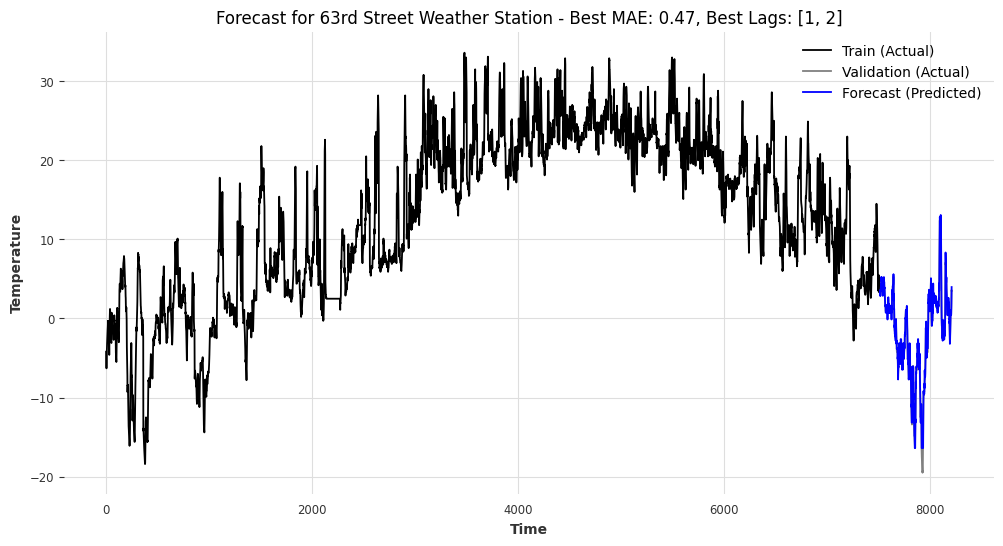

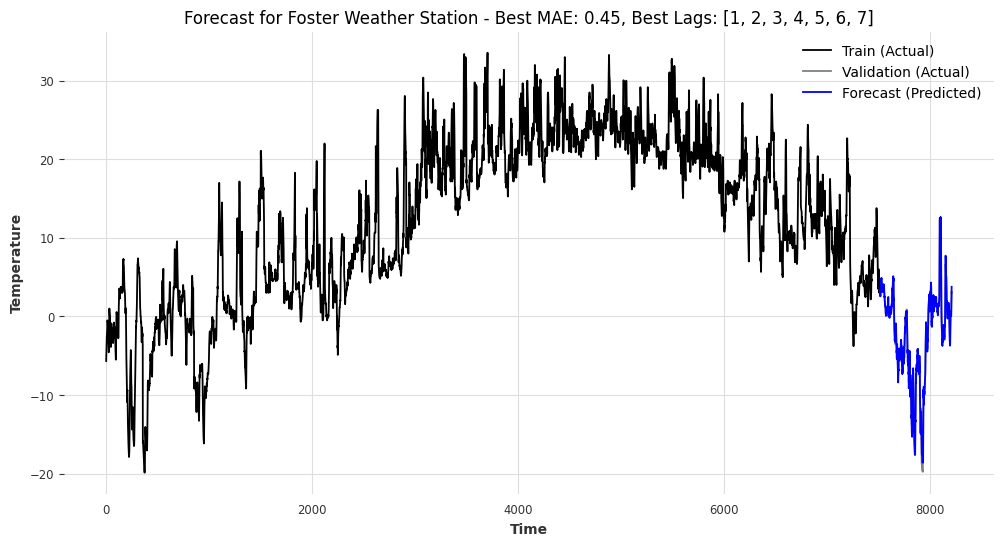

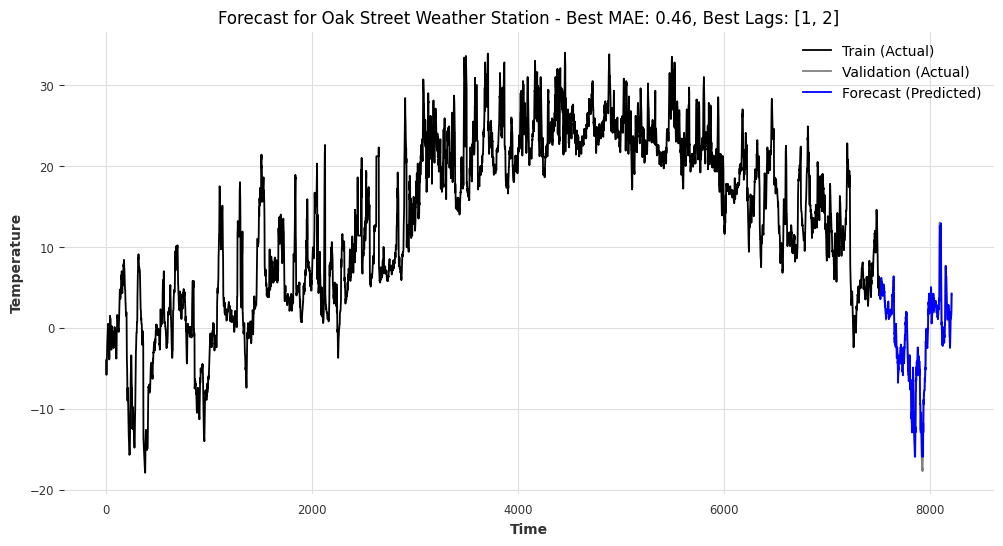

In [39]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load and preprocess the data (as before)
file_path = 'C:/Users/natha/OneDrive/Bureau/Interview trainings/Coding/Aquatic/Weather_Forecast_Ideas/data/chicago_beach_weather.csv'
weather_data = pd.read_csv(file_path)
weather_data['Measurement Timestamp'] = pd.to_datetime(weather_data['Measurement Timestamp'])
weather_data.set_index('Measurement Timestamp', inplace=True)

df_pivot = weather_data.pivot(columns='Station Name', values='Air Temperature')
df_pivot = df_pivot.fillna(method='ffill').fillna(method='bfill')

# Define lag configurations to test
lag_configs = [
    [1, 2],
    [1, 2, 3],           # Short lags
    [1, 2, 3, 4, 5, 6, 7],  # Full week of hourly lags
    [24, 48, 72],        # Daily lags
    [1, 2, 3, 24, 48],   # Mixed short-term and daily lags
]

# Dictionary to store best results for each station
best_mae_scores = {}
best_lag_configurations = {}
best_forecast_results = {}

# Loop over each station to perform the grid search
for station in df_pivot.columns:
    best_mae = float("inf")
    best_lags = None
    best_y_train, best_y_val, best_y_pred = None, None, None  # To store the best model's results for plotting

    for lags in lag_configs:
        lagged_data = pd.DataFrame()
        
        # Create lagged features for the current configuration
        for lag in lags:
            lagged_data[f'{station}_lag{lag}'] = df_pivot[station].shift(lag)
        
        # Add target variable for current station
        lagged_data[f'target_{station}'] = df_pivot[station]
        lagged_data = lagged_data.dropna()
        
        # Train-validation split (before and in December 2016)
        train_data = lagged_data[lagged_data.index < '2016-12-01']
        val_data = lagged_data[(lagged_data.index >= '2016-12-01') & (lagged_data.index <= '2016-12-31')]
        
        X_train = train_data.drop(columns=[f'target_{station}'])
        y_train = train_data[f'target_{station}']
        X_val = val_data.drop(columns=[f'target_{station}'])
        y_val = val_data[f'target_{station}']
        
        # Train the XGBoost model
        model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
        model.fit(X_train, y_train)
        
        # Predict and calculate MAE
        y_pred = model.predict(X_val)
        mae = mean_absolute_error(y_val, y_pred)
        
        # Update best configuration if current MAE is lower
        if mae < best_mae:
            best_mae = mae
            best_lags = lags
            best_y_train, best_y_val, best_y_pred = y_train, y_val, y_pred  # Store results for best model
    
    # Store the best MAE, lag configuration, and forecast results for the station
    best_mae_scores[station] = best_mae
    best_lag_configurations[station] = best_lags
    best_forecast_results[station] = {
        'train': best_y_train,
        'validation': best_y_val,
        'forecast': best_y_pred
    }

# Print best lag configuration and MAE for each station
print("Best Lag Configurations and MAE for Each Station:")
for station, mae in best_mae_scores.items():
    print(f"Station: {station}, Best MAE: {mae:.2f}, Best Lags: {best_lag_configurations[station]}")

# Plot the training, validation, and forecast results for each station
for station, results in best_forecast_results.items():
    plt.figure(figsize=(12, 6))
    plt.plot(results['train'].values, label="Train (Actual)", color="black")
    plt.plot(range(len(results['train']), len(results['train']) + len(results['validation'])), 
             results['validation'].values, label="Validation (Actual)", color="gray")
    plt.plot(range(len(results['train']), len(results['train']) + len(results['forecast'])), 
             results['forecast'], label="Forecast (Predicted)", color="blue")
    
    plt.legend()
    plt.title(f"Forecast for {station} - Best MAE: {best_mae_scores[station]:.2f}, Best Lags: {best_lag_configurations[station]}")
    plt.xlabel("Time")
    plt.ylabel("Temperature")
    plt.show()


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 7513, number of used features: 21
[LightGBM] [Info] Start training from score 13.321776
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 7513, number of used features: 21
[LightGBM] [Info] Start training from score 12.609529
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of te

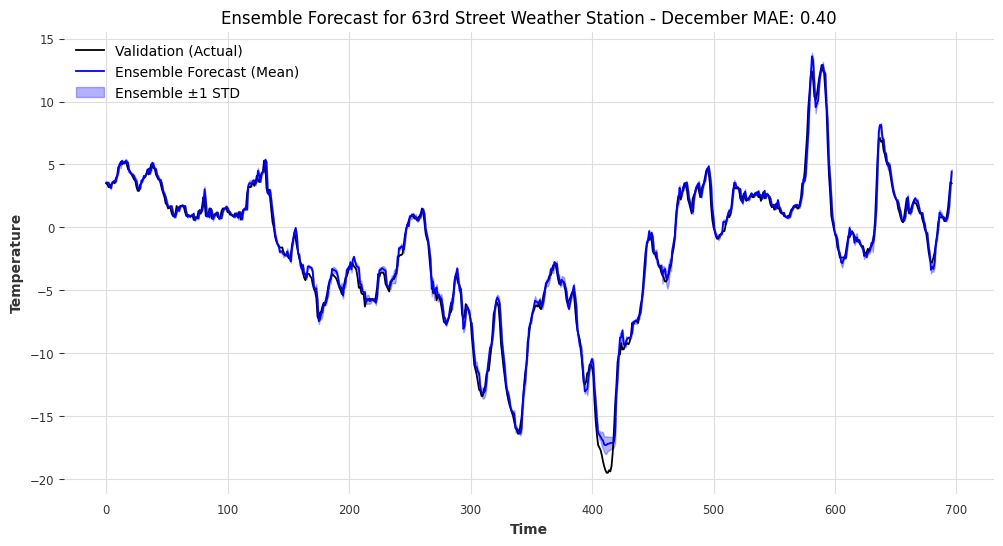

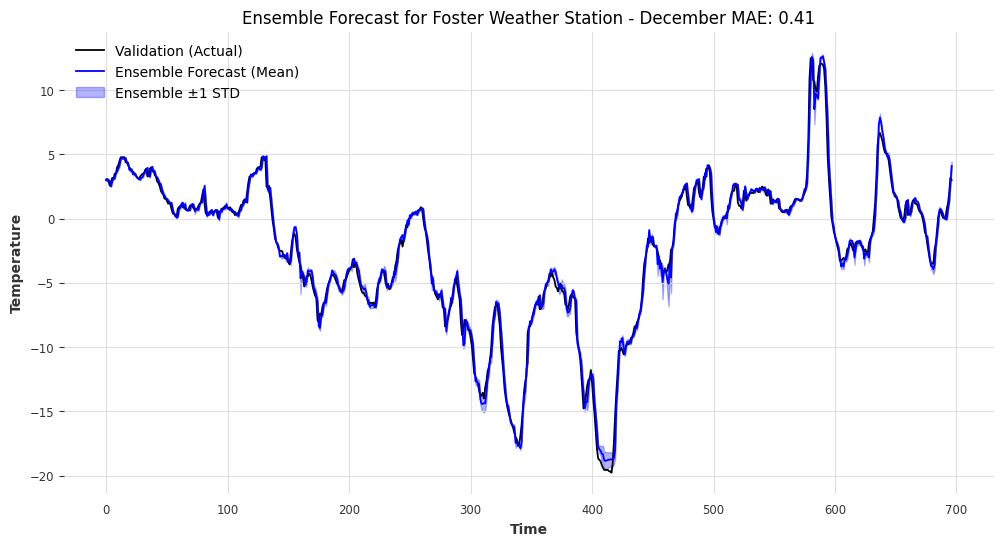

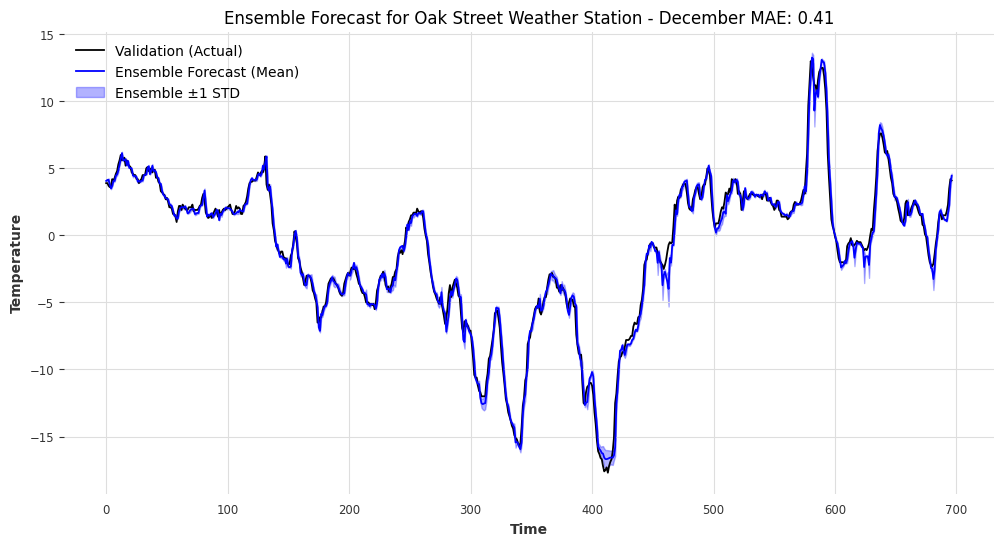

In [44]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the data
file_path = 'C:/Users/natha/OneDrive/Bureau/Interview trainings/Coding/Aquatic/Weather_Forecast_Ideas/data/chicago_beach_weather.csv'
weather_data = pd.read_csv(file_path)
weather_data['Measurement Timestamp'] = pd.to_datetime(weather_data['Measurement Timestamp'])
weather_data.set_index('Measurement Timestamp', inplace=True)

# Pivot the data by station name and fill any missing values
df_pivot = weather_data.pivot(columns='Station Name', values='Air Temperature')
df_pivot = df_pivot.fillna(method='ffill').fillna(method='bfill')

# Generate lagged features (same lags for each model)
station_names = df_pivot.columns
lagged_data = pd.DataFrame()
for station in station_names:
    for lag in range(1, 8):  # Use lags from 1 to 7 hours as an example
        lagged_data[f'{station}_lag{lag}'] = df_pivot[station].shift(lag)
    lagged_data[f'target_{station}'] = df_pivot[station]

# Drop rows with NaN values after creating lags
lagged_data = lagged_data.dropna()

# Split data into training (before December) and validation (December only)
train_data = lagged_data[lagged_data.index < '2016-12-01']
val_data = lagged_data[(lagged_data.index >= '2016-12-01') & (lagged_data.index <= '2016-12-31')]

# Dictionary to store results for each station
mae_scores = {}
ensemble_forecast_results = {}

# Train and predict for each station using an ensemble
for station in station_names:
    # Define X and y for the current station
    X_train = train_data.drop(columns=[f'target_{s}' for s in station_names])
    y_train = train_data[f'target_{station}']
    X_val = val_data.drop(columns=[f'target_{s}' for s in station_names])
    y_val = val_data[f'target_{station}']
    
    # Initialize models
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
    lgb_model = lgb.LGBMRegressor(n_estimators=100)
    rf_model = RandomForestRegressor(n_estimators=100)
    
    # Train each model
    xgb_model.fit(X_train, y_train)
    lgb_model.fit(X_train, y_train)
    rf_model.fit(X_train, y_train)
    
    # Predict for December and store individual predictions
    xgb_pred = xgb_model.predict(X_val)
    lgb_pred = lgb_model.predict(X_val)
    rf_pred = rf_model.predict(X_val)
    
    # Calculate ensemble mean and standard deviation
    ensemble_preds = np.array([xgb_pred, lgb_pred, rf_pred])
    ensemble_mean = ensemble_preds.mean(axis=0)
    ensemble_std = ensemble_preds.std(axis=0)
    
    # Calculate MAE for the ensemble mean
    mae_scores[station] = mean_absolute_error(y_val, ensemble_mean)
    
    # Store results for plotting
    ensemble_forecast_results[station] = {
        'train': y_train,
        'validation': y_val,
        'ensemble_mean': ensemble_mean,
        'ensemble_std': ensemble_std
    }

# Print MAE scores for each station
print("Ensemble MAE for Each Station:")
for station, mae in mae_scores.items():
    print(f"Station: {station}, MAE: {mae:.2f}")

# Plot only the validation (December) and ensemble forecast (mean ± std) for each station
for station, results in ensemble_forecast_results.items():
    plt.figure(figsize=(12, 6))
    
    # Plot the actual validation data for December
    plt.plot(results['validation'].values, label="Validation (Actual)", color="black")
    
    # Plot the ensemble forecast mean for December
    plt.plot(results['ensemble_mean'], label="Ensemble Forecast (Mean)", color="blue")
    
    # Plot the confidence interval (mean ± std)
    plt.fill_between(range(len(results['ensemble_mean'])), 
                     results['ensemble_mean'] - results['ensemble_std'], 
                     results['ensemble_mean'] + results['ensemble_std'], 
                     color="blue", alpha=0.3, label="Ensemble ±1 STD")
    
    plt.legend()
    plt.title(f"Ensemble Forecast for {station} - December MAE: {mae_scores[station]:.2f}")
    plt.xlabel("Time")
    plt.ylabel("Temperature")
    plt.show()


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 7513, number of used features: 21
[LightGBM] [Info] Start training from score 13.321776
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 7513, number of used features: 21
[LightGBM] [Info] Start training from score 12.609529
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of te

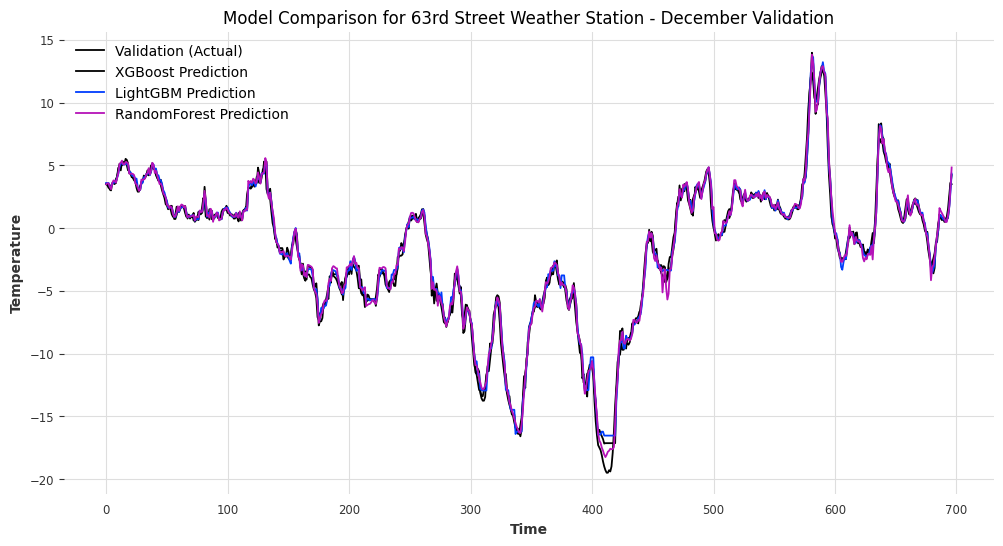

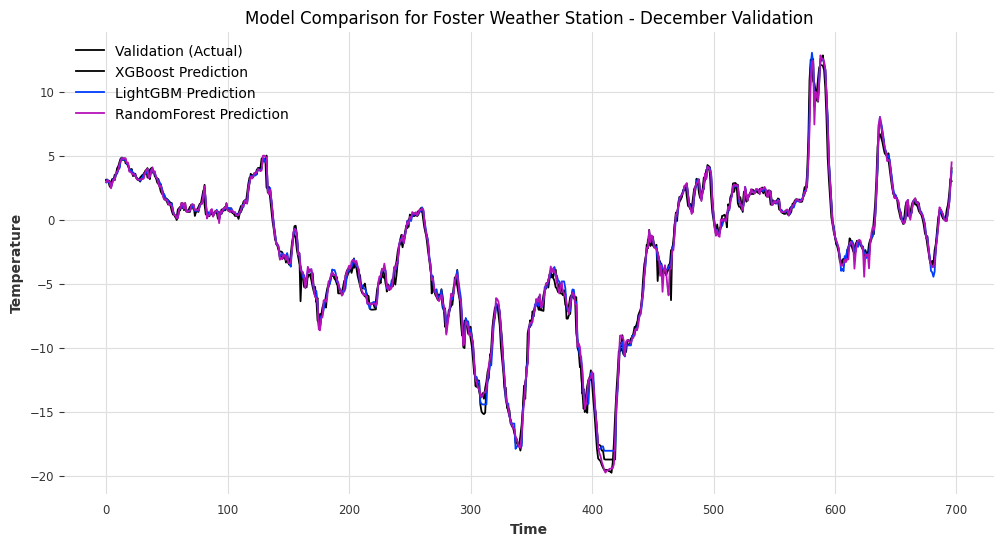

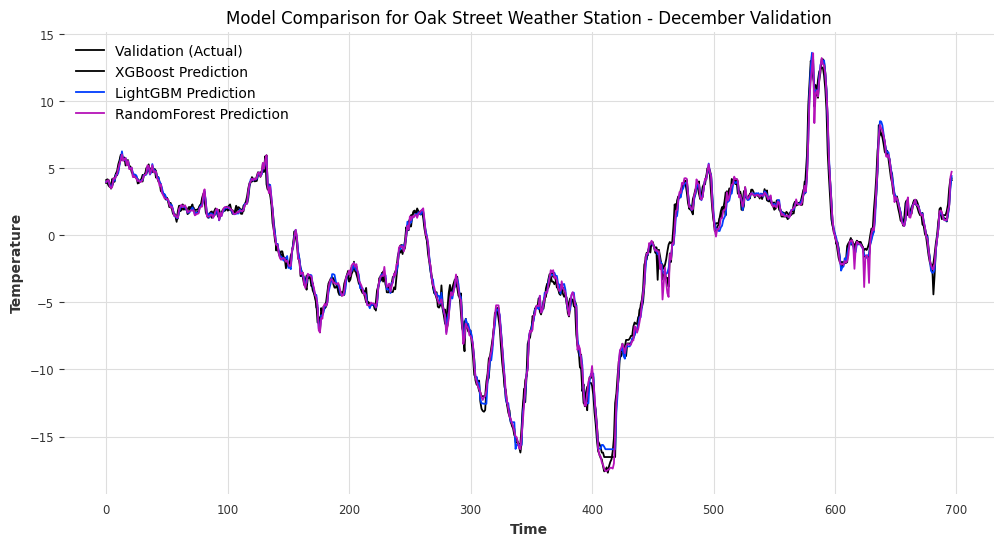

In [45]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the data
file_path = 'C:/Users/natha/OneDrive/Bureau/Interview trainings/Coding/Aquatic/Weather_Forecast_Ideas/data/chicago_beach_weather.csv'
weather_data = pd.read_csv(file_path)
weather_data['Measurement Timestamp'] = pd.to_datetime(weather_data['Measurement Timestamp'])
weather_data.set_index('Measurement Timestamp', inplace=True)

# Pivot the data by station name and fill any missing values
df_pivot = weather_data.pivot(columns='Station Name', values='Air Temperature')
df_pivot = df_pivot.fillna(method='ffill').fillna(method='bfill')

# Generate lagged features (same lags for each model)
station_names = df_pivot.columns
lagged_data = pd.DataFrame()
for station in station_names:
    for lag in range(1, 8):  # Use lags from 1 to 7 hours as an example
        lagged_data[f'{station}_lag{lag}'] = df_pivot[station].shift(lag)
    lagged_data[f'target_{station}'] = df_pivot[station]

# Drop rows with NaN values after creating lags
lagged_data = lagged_data.dropna()

# Split data into training (before December) and validation (December only)
train_data = lagged_data[lagged_data.index < '2016-12-01']
val_data = lagged_data[(lagged_data.index >= '2016-12-01') & (lagged_data.index <= '2016-12-31')]

# Dictionary to store individual MAE scores for each model per station
mae_scores = {station: {} for station in station_names}
forecast_results = {station: {} for station in station_names}

# Train and predict for each station using each model individually
for station in station_names:
    # Define X and y for the current station
    X_train = train_data.drop(columns=[f'target_{s}' for s in station_names])
    y_train = train_data[f'target_{station}']
    X_val = val_data.drop(columns=[f'target_{s}' for s in station_names])
    y_val = val_data[f'target_{station}']
    
    # Initialize models
    models = {
        "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100),
        "LightGBM": lgb.LGBMRegressor(n_estimators=100),
        "RandomForest": RandomForestRegressor(n_estimators=100)
    }
    
    # Train each model and predict
    for model_name, model in models.items():
        # Train the model
        model.fit(X_train, y_train)
        
        # Predict on the validation set
        predictions = model.predict(X_val)
        
        # Calculate MAE for the model
        mae_scores[station][model_name] = mean_absolute_error(y_val, predictions)
        
        # Store results for plotting
        forecast_results[station][model_name] = {
            'validation': y_val,
            'predictions': predictions
        }

# Print MAE scores for each model per station
print("MAE for Each Model and Station:")
for station, scores in mae_scores.items():
    print(f"\nStation: {station}")
    for model_name, mae in scores.items():
        print(f"  {model_name}: MAE = {mae:.2f}")

# Plot validation (actual) vs. each model's predictions for each station
for station, results in forecast_results.items():
    plt.figure(figsize=(12, 6))
    
    # Plot the actual validation data for December
    plt.plot(results['XGBoost']['validation'].values, label="Validation (Actual)", color="black")
    
    # Plot predictions from each model
    for model_name, result in results.items():
        plt.plot(result['predictions'], label=f"{model_name} Prediction")
    
    plt.legend()
    plt.title(f"Model Comparison for {station} - December Validation")
    plt.xlabel("Time")
    plt.ylabel("Temperature")
    plt.show()


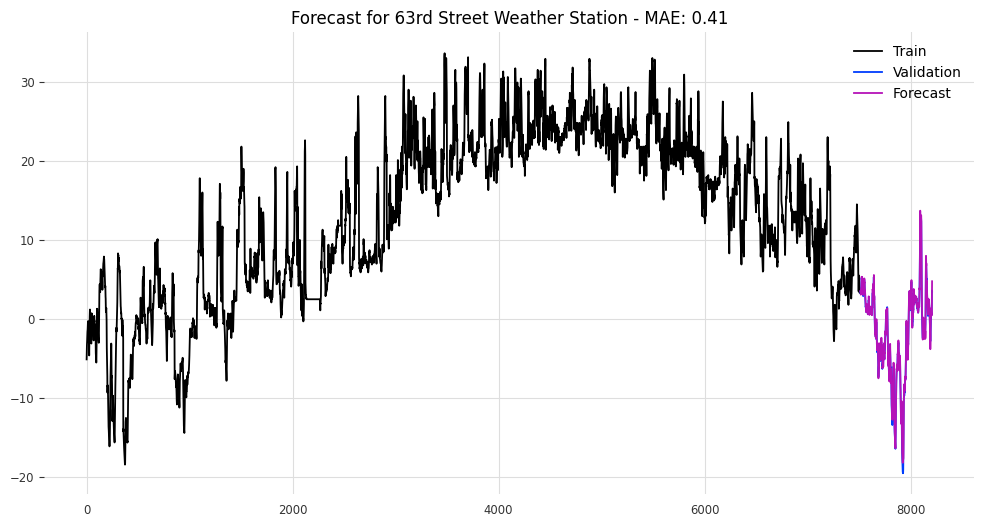

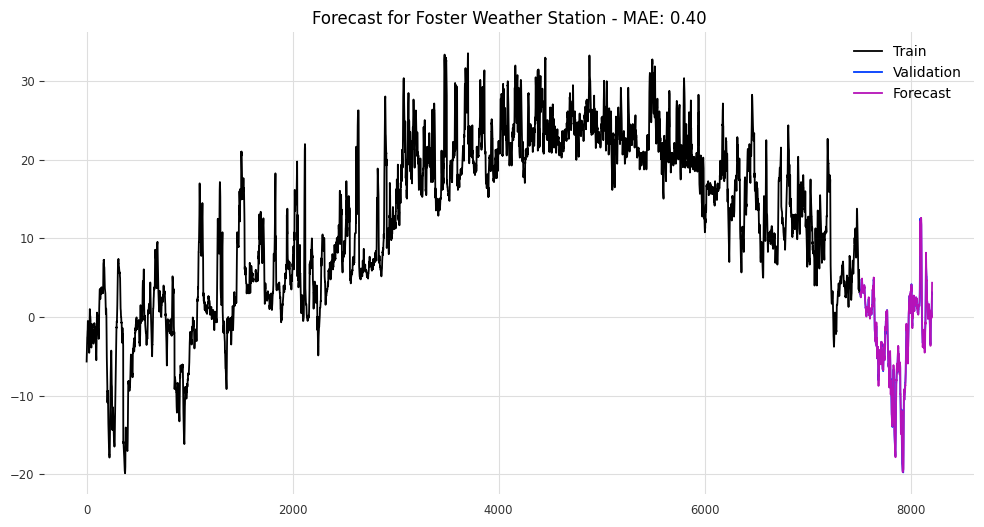

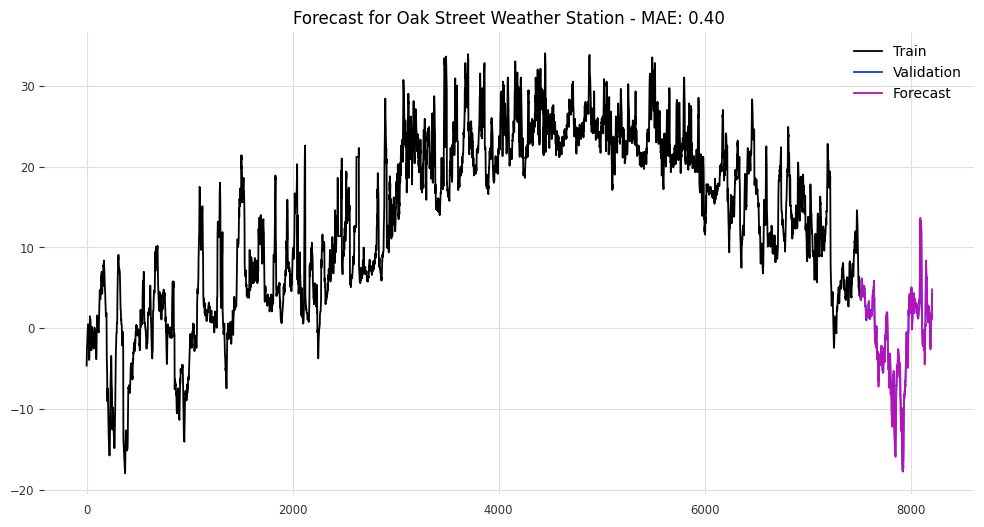

MAE scores for each station:
{'63rd Street Weather Station': 0.4105394548063124, 'Foster Weather Station': 0.40455308464849365, 'Oak Street Weather Station': 0.40439311334289824}


In [46]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd

# Load the CSV file to examine its contents
file_path = 'C:/Users/natha/OneDrive/Bureau/Interview trainings/Coding/Aquatic/Weather_Forecast_Ideas/data/chicago_beach_weather.csv'
weather_data = pd.read_csv(file_path)

# Display the first few rows of the data to understand its structure
weather_data.head()

# Preprocess the data as required
weather_data['Measurement Timestamp'] = pd.to_datetime(weather_data['Measurement Timestamp'])
weather_data.set_index('Measurement Timestamp', inplace=True)

# Pivot the data by station name and fill any missing values
df_pivot = weather_data.pivot(columns='Station Name', values='Air Temperature')
df_pivot = df_pivot.fillna(method='ffill').fillna(method='bfill')

# Generate lagged features
station_names = df_pivot.columns
lagged_data = pd.DataFrame()

# Create lagged features for each station
for station in station_names:
    for lag in range(1, 8):  # 7 lag days
        lagged_data[f'{station}_lag{lag}'] = df_pivot[station].shift(lag)

# Add each station's current value as a target
for station in station_names:
    lagged_data[f'target_{station}'] = df_pivot[station]

# Drop rows with NaN values after creating lags
lagged_data = lagged_data.dropna()

# Split data into training (before December) and validation (December only)
train_data = lagged_data[lagged_data.index < '2016-12-01']
val_data = lagged_data[(lagged_data.index >= '2016-12-01') & (lagged_data.index <= '2016-12-31')]

# Dictionary to store results for each station
mae_scores = {}
forecast_results = {}

# Train and predict for each station
for station in station_names:
    # Define X and y for the current station
    X_train = train_data.drop(columns=[f'target_{s}' for s in station_names])
    y_train = train_data[f'target_{station}']
    X_val = val_data.drop(columns=[f'target_{s}' for s in station_names])
    y_val = val_data[f'target_{station}']

    # Train the RandomForest model
    model = RandomForestRegressor(n_estimators=100)
    model.fit(X_train, y_train)

    # Predict and compute MAE for validation set
    y_pred = model.predict(X_val)
    mae_scores[station] = mean_absolute_error(y_val, y_pred)

    # Store the forecast, validation, and training sets for plotting
    forecast_results[station] = {
        'train': y_train,
        'validation': y_val,
        'forecast': y_pred
    }

# Plot the forecast, validation, and training sets for each station
for station in station_names:
    results = forecast_results[station]
    
    plt.figure(figsize=(12, 6))
    plt.plot(results['train'].values, label="Train")
    plt.plot(range(len(results['train']), len(results['train']) + len(results['validation'])), 
             results['validation'].values, label="Validation")
    plt.plot(range(len(results['train']), len(results['train']) + len(results['forecast'])), 
             results['forecast'], label="Forecast")
    plt.legend()
    plt.title(f"Forecast for {station} - MAE: {mae_scores[station]:.2f}")
    plt.show()

# Display MAE scores for each station
print("MAE scores for each station:")
print(mae_scores)

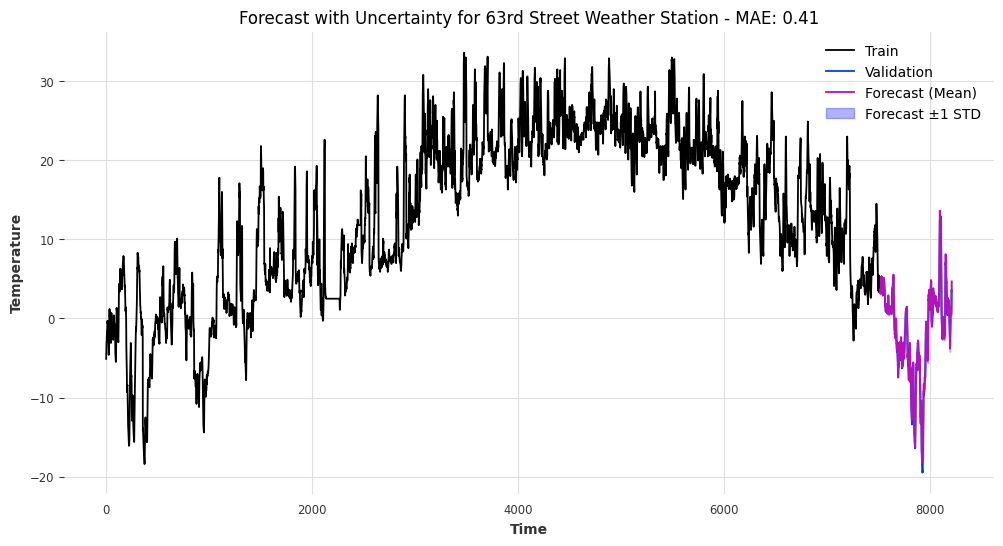

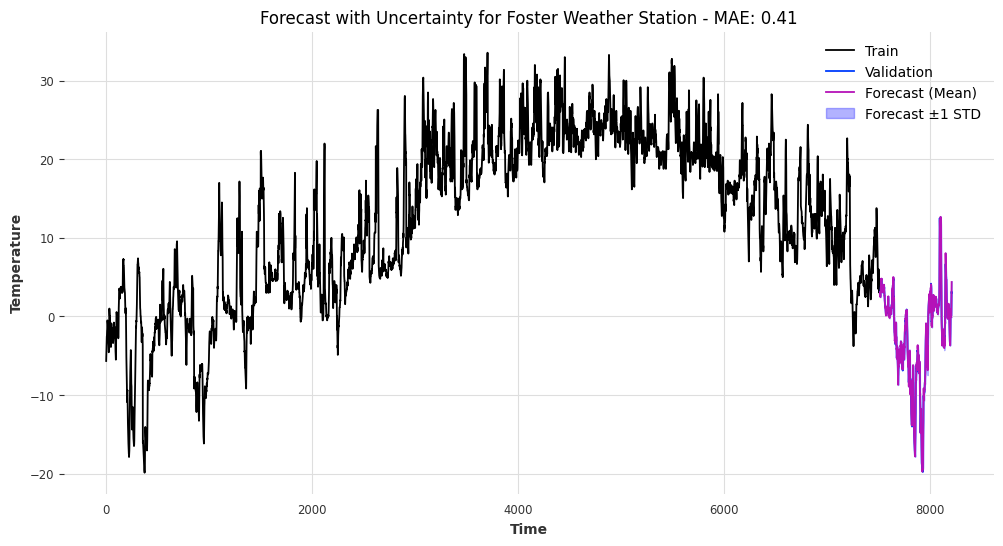

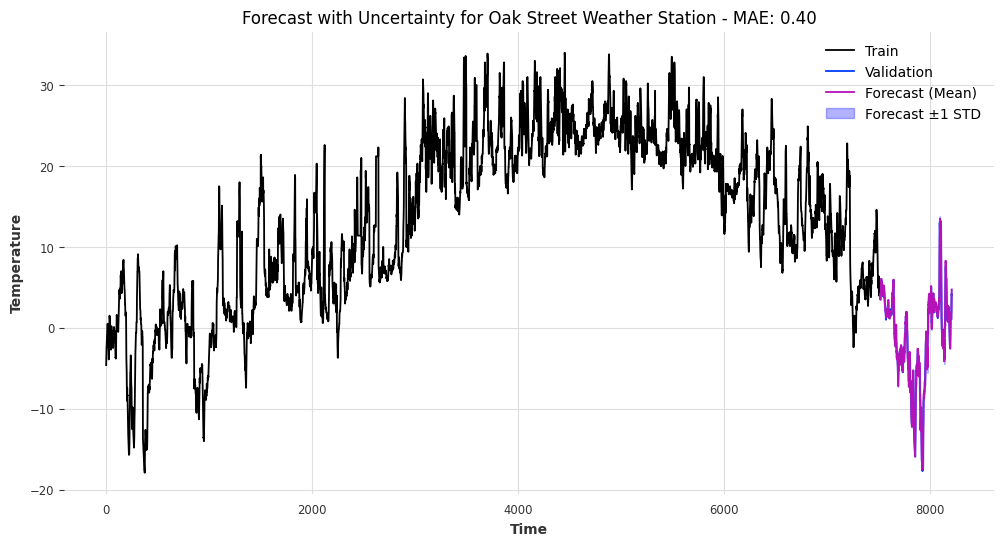

MAE scores for each station:
{'63rd Street Weather Station': 0.40766040172166396, 'Foster Weather Station': 0.40762539454806335, 'Oak Street Weather Station': 0.40409713055954094}


In [47]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load the CSV file to examine its contents
file_path = 'C:/Users/natha/OneDrive/Bureau/Interview trainings/Coding/Aquatic/Weather_Forecast_Ideas/data/chicago_beach_weather.csv'
weather_data = pd.read_csv(file_path)

# Preprocess the data as required
weather_data['Measurement Timestamp'] = pd.to_datetime(weather_data['Measurement Timestamp'])
weather_data.set_index('Measurement Timestamp', inplace=True)

# Pivot the data by station name and fill any missing values
df_pivot = weather_data.pivot(columns='Station Name', values='Air Temperature')
df_pivot = df_pivot.fillna(method='ffill').fillna(method='bfill')

# Generate lagged features
station_names = df_pivot.columns
lagged_data = pd.DataFrame()

# Create lagged features for each station
for station in station_names:
    for lag in range(1, 8):  # 7 lag days
        lagged_data[f'{station}_lag{lag}'] = df_pivot[station].shift(lag)

# Add each station's current value as a target
for station in station_names:
    lagged_data[f'target_{station}'] = df_pivot[station]

# Drop rows with NaN values after creating lags
lagged_data = lagged_data.dropna()

# Split data into training (before December) and validation (December only)
train_data = lagged_data[lagged_data.index < '2016-12-01']
val_data = lagged_data[(lagged_data.index >= '2016-12-01') & (lagged_data.index <= '2016-12-31')]

# Parameters for ensemble
n_estimators = 100  # Number of trees in each model
ensemble_size = 10  # Number of Random Forest models in the ensemble

# Dictionary to store results for each station
mae_scores = {}
forecast_results = {}

# Train and predict for each station with uncertainty quantification
for station in station_names:
    # Define X and y for the current station
    X_train = train_data.drop(columns=[f'target_{s}' for s in station_names])
    y_train = train_data[f'target_{station}']
    X_val = val_data.drop(columns=[f'target_{s}' for s in station_names])
    y_val = val_data[f'target_{station}']

    # Initialize ensemble predictions
    ensemble_preds = []

    # Build an ensemble of Random Forest models
    for i in range(ensemble_size):
        model = RandomForestRegressor(n_estimators=n_estimators, random_state=i)
        model.fit(X_train, y_train)
        
        # Predict on the validation set
        y_pred = model.predict(X_val)
        ensemble_preds.append(y_pred)

    # Convert list of predictions to a numpy array for easy manipulation
    ensemble_preds = np.array(ensemble_preds)

    # Calculate mean and standard deviation of predictions for uncertainty quantification
    ensemble_mean = ensemble_preds.mean(axis=0)
    ensemble_std = ensemble_preds.std(axis=0)  # This is the uncertainty measure

    # Calculate MAE for the ensemble mean
    mae_scores[station] = mean_absolute_error(y_val, ensemble_mean)

    # Store the forecast, validation, and uncertainty results for plotting
    forecast_results[station] = {
        'train': y_train,
        'validation': y_val,
        'forecast_mean': ensemble_mean,
        'forecast_std': ensemble_std
    }

# Plot the forecast mean, validation, and uncertainty (mean ± std) for each station
for station in station_names:
    results = forecast_results[station]
    
    plt.figure(figsize=(12, 6))
    plt.plot(results['train'].values, label="Train")
    plt.plot(range(len(results['train']), len(results['train']) + len(results['validation'])), 
             results['validation'].values, label="Validation")
    plt.plot(range(len(results['train']), len(results['train']) + len(results['forecast_mean'])), 
             results['forecast_mean'], label="Forecast (Mean)")

    # Plot the uncertainty as a shaded region (forecast ± 1 std)
    plt.fill_between(range(len(results['train']), len(results['train']) + len(results['forecast_mean'])), 
                     results['forecast_mean'] - results['forecast_std'], 
                     results['forecast_mean'] + results['forecast_std'], 
                     color="blue", alpha=0.3, label="Forecast ±1 STD")
    
    plt.legend()
    plt.title(f"Forecast with Uncertainty for {station} - MAE: {mae_scores[station]:.2f}")
    plt.xlabel("Time")
    plt.ylabel("Temperature")
    plt.show()

# Display MAE scores for each station
print("MAE scores for each station:")
print(mae_scores)

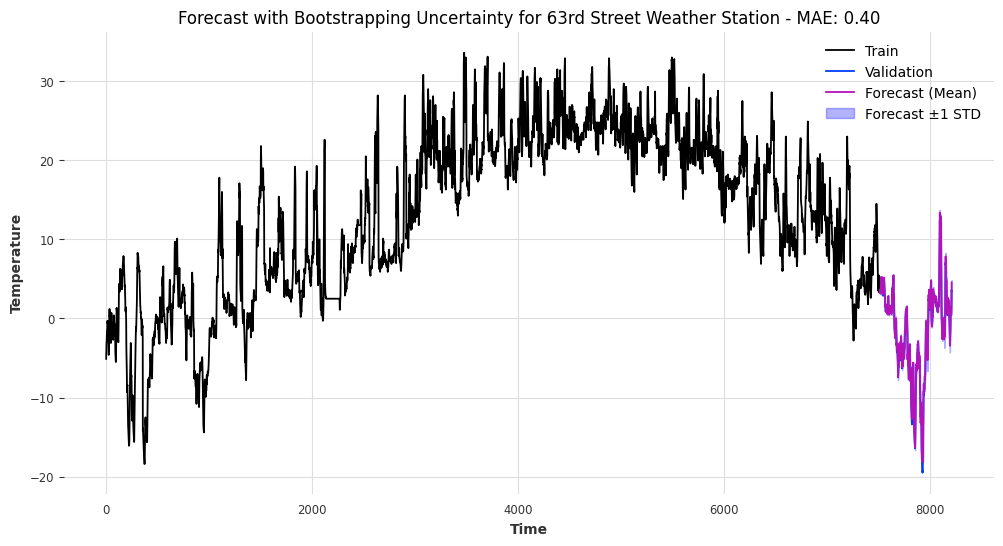

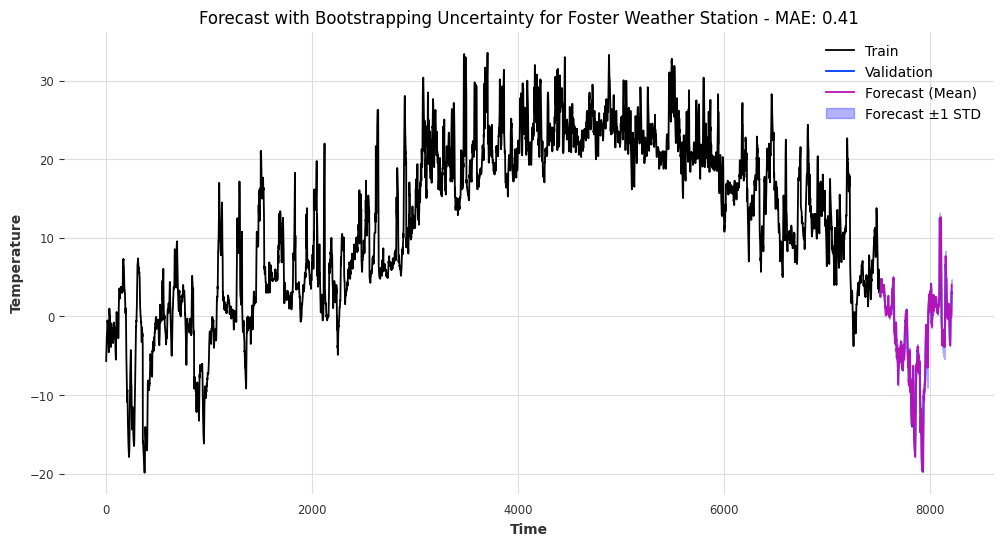

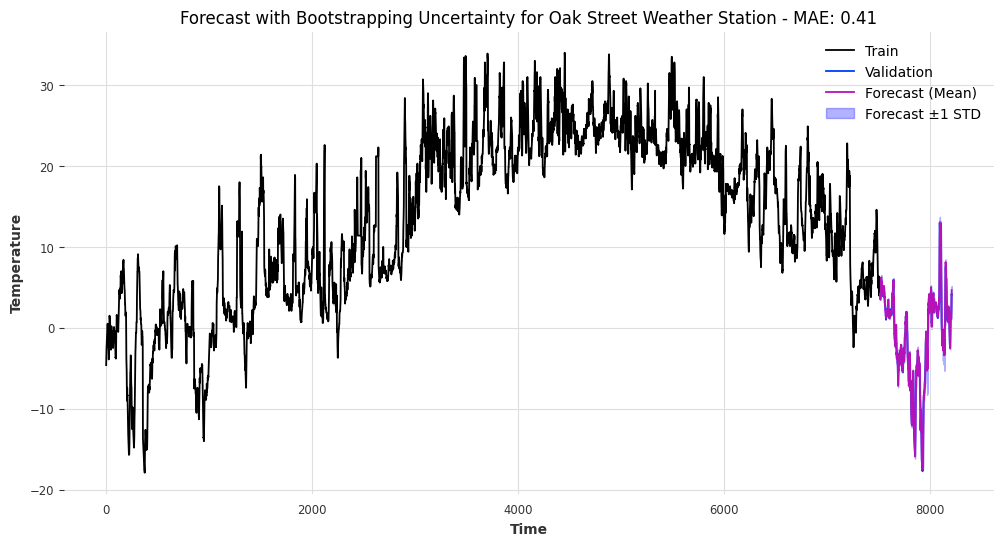

MAE scores for each station:
{'63rd Street Weather Station': 0.4022489239598274, 'Foster Weather Station': 0.4098091104734577, 'Oak Street Weather Station': 0.4092553802008609}


In [48]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.utils import resample

# Load the CSV file to examine its contents
file_path = 'C:/Users/natha/OneDrive/Bureau/Interview trainings/Coding/Aquatic/Weather_Forecast_Ideas/data/chicago_beach_weather.csv'
weather_data = pd.read_csv(file_path)

# Preprocess the data as required
weather_data['Measurement Timestamp'] = pd.to_datetime(weather_data['Measurement Timestamp'])
weather_data.set_index('Measurement Timestamp', inplace=True)

# Pivot the data by station name and fill any missing values
df_pivot = weather_data.pivot(columns='Station Name', values='Air Temperature')
df_pivot = df_pivot.fillna(method='ffill').fillna(method='bfill')

# Generate lagged features
station_names = df_pivot.columns
lagged_data = pd.DataFrame()

# Create lagged features for each station
for station in station_names:
    for lag in range(1, 8):  # 7 lag days
        lagged_data[f'{station}_lag{lag}'] = df_pivot[station].shift(lag)

# Add each station's current value as a target
for station in station_names:
    lagged_data[f'target_{station}'] = df_pivot[station]

# Drop rows with NaN values after creating lags
lagged_data = lagged_data.dropna()

# Split data into training (before December) and validation (December only)
train_data = lagged_data[lagged_data.index < '2016-12-01']
val_data = lagged_data[(lagged_data.index >= '2016-12-01') & (lagged_data.index <= '2016-12-31')]

# Parameters for bootstrapping
n_estimators = 100  # Number of trees in each model
bootstrap_size = 10  # Number of bootstrap samples/models

# Dictionary to store results for each station
mae_scores = {}
forecast_results = {}

# Train and predict for each station with bootstrapping
for station in station_names:
    # Define X and y for the current station
    X_train = train_data.drop(columns=[f'target_{s}' for s in station_names])
    y_train = train_data[f'target_{station}']
    X_val = val_data.drop(columns=[f'target_{s}' for s in station_names])
    y_val = val_data[f'target_{station}']

    # Initialize list to hold predictions from each bootstrap model
    bootstrap_preds = []

    # Bootstrap sampling and training
    for i in range(bootstrap_size):
        # Resample the training data with replacement to create a bootstrap sample
        X_train_bootstrap, y_train_bootstrap = resample(X_train, y_train, random_state=i)

        # Train a RandomForest model on the bootstrap sample
        model = RandomForestRegressor(n_estimators=n_estimators, random_state=i)
        model.fit(X_train_bootstrap, y_train_bootstrap)

        # Predict on the validation set
        y_pred = model.predict(X_val)
        bootstrap_preds.append(y_pred)

    # Convert list of predictions to a numpy array for easy manipulation
    bootstrap_preds = np.array(bootstrap_preds)

    # Calculate mean and standard deviation of predictions for uncertainty quantification
    bootstrap_mean = bootstrap_preds.mean(axis=0)
    bootstrap_std = bootstrap_preds.std(axis=0)  # This is the uncertainty measure

    # Calculate MAE for the bootstrap mean
    mae_scores[station] = mean_absolute_error(y_val, bootstrap_mean)

    # Store the forecast, validation, and uncertainty results for plotting
    forecast_results[station] = {
        'train': y_train,
        'validation': y_val,
        'forecast_mean': bootstrap_mean,
        'forecast_std': bootstrap_std
    }

# Plot the forecast mean, validation, and uncertainty (mean ± std) for each station
for station in station_names:
    results = forecast_results[station]
    
    plt.figure(figsize=(12, 6))
    plt.plot(results['train'].values, label="Train")
    plt.plot(range(len(results['train']), len(results['train']) + len(results['validation'])), 
             results['validation'].values, label="Validation")
    plt.plot(range(len(results['train']), len(results['train']) + len(results['forecast_mean'])), 
             results['forecast_mean'], label="Forecast (Mean)")

    # Plot the uncertainty as a shaded region (forecast ± 1 std)
    plt.fill_between(range(len(results['train']), len(results['train']) + len(results['forecast_mean'])), 
                     results['forecast_mean'] - results['forecast_std'], 
                     results['forecast_mean'] + results['forecast_std'], 
                     color="blue", alpha=0.3, label="Forecast ±1 STD")
    
    plt.legend()
    plt.title(f"Forecast with Bootstrapping Uncertainty for {station} - MAE: {mae_scores[station]:.2f}")
    plt.xlabel("Time")
    plt.ylabel("Temperature")
    plt.show()

# Display MAE scores for each station
print("MAE scores for each station:")
print(mae_scores)
